In [50]:
%matplotlib widget
import datetime as dt
import locale
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests

In [81]:
locale.setlocale(locale.LC_ALL, 'ja_JP.utf8')

'ja_JP.utf8'

In [93]:
dt.datetime.strftime(dt.datetime.now(), "%x")

'2020年07月27日'

In [2]:
COVID_JSON = "https://data.covid19japan.com/summary/latest.json"
NHK_JSON = "https://www3.nhk.or.jp/news/special/coronavirus/data/47newpatients-data.json"
PATIENT_JSON = "https://data.covid19japan.com/patient_data/latest.json"

In [3]:
with open("prefecture_names.json") as prefs, open("regions.json") as regs:
    prefecture_names = json.load(prefs)
    prefecture_names_r = {v: k for k, v in prefecture_names.items()}
    regions = json.load(regs)

In [4]:
data_nhk_str = requests.get(NHK_JSON).text
data_covid_str = requests.get(COVID_JSON).text

In [5]:
data_nhk = json.loads(data_nhk_str)
dates_nhk = [dt.datetime.strptime("2020/" + date, "%Y/%m/%d") for date in data_nhk["category"]]
counts_nhk = {prefecture["name"]: prefecture["data"] for prefecture in data_nhk["data47"]}
df = pd.DataFrame(counts_nhk, index=dates_nhk)
df.index.set_names("date", inplace=True)
df["全国"] = df.sum(axis=1)
print(df["全国"].sum())
df.tail()

29971


北海道  青森県  岩手県  宮城県  秋田県  山形県  福島県  茨城県  栃木県  群馬県  ...  高知県  福岡県  \
date                                                          ...             
2020-07-22    6    0    0    2    0    0    1    5    3    5  ...    1   61   
2020-07-23    4    0    0    2    0    0    1    2    5    3  ...    0   66   
2020-07-24    6    0    0    0    0    0    0    2    4    0  ...    1   52   
2020-07-25    9    0    0    2    1    0    0    0    8    2  ...    0   50   
2020-07-26    5    0    0    0    1    0    0    3    4    0  ...    1   90   

            佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県   全国  
date                                                 
2020-07-22    6    3    2    0    3     2    2  791  
2020-07-23    2    0    3    0    4    15    5  966  
2020-07-24    6    1    1    0    9    14   10  772  
2020-07-25    3    0    2    0   19     8   14  792  
2020-07-26    1    1   21    0    8     5    6  829  

[5 rows x 48 columns]

In [6]:
data_covid = json.loads(data_covid_str)
data_covid["prefectures"] = [pref for pref in data_covid["prefectures"] if "pseudoPrefecture" not in pref]
start_date_covid = dt.datetime.strptime(data_covid["prefectures"][0]["dailyConfirmedStartDate"], "%Y-%m-%d")
end_date_covid = start_date_covid + dt.timedelta(days=len(data_covid["prefectures"][0]["dailyConfirmedCount"]) - 1)
dates_covid = pd.date_range(start_date_covid, end_date_covid)
counts_covid = {prefecture_names_r[pref["name"]]: pref["dailyConfirmedCount"] for pref in data_covid["prefectures"]}
df_covid = pd.DataFrame(counts_covid, index=dates_covid)
df_covid["全国"] = df_covid.sum(axis=1)
df_covid = df_covid[df.columns]
print(df_covid["全国"].sum())
df_covid.tail()

29982


北海道  青森県  岩手県  宮城県  秋田県  山形県  福島県  茨城県  栃木県  群馬県  ...  高知県  福岡県  \
2020-07-22    6    0    0    2    0    0    1    5    3    5  ...    1   61   
2020-07-23    4    0    0    2    0    0    1    2    5    3  ...    0   66   
2020-07-24    6    0    0    0    0    0    0    2    4    0  ...    1   52   
2020-07-25    9    0    0    2    1    0    0    0    8    2  ...    0   50   
2020-07-26    5    0    0    0    1    0    0    3    4    0  ...    1   90   

            佐賀県  長崎県  熊本県  大分県  宮崎県  鹿児島県  沖縄県   全国  
2020-07-22    6    3    2    0    3     2    2  792  
2020-07-23    2    0    3    0    4    15    5  965  
2020-07-24    6    1    1    0    9    14   10  772  
2020-07-25    3    0    2    0   19     8   14  793  
2020-07-26    1    1   21    0    8     5    6  829  

[5 rows x 48 columns]

In [7]:
fig, ax = plt.subplots()
df.plot(y="全国", ax=ax, label="NHK")
df_covid.plot(y="全国", ax=ax, label="COVID-19 Japan")
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
tidy = df.reset_index().melt(id_vars="date", var_name="prefecture", value_name="cases")
tidy.tail()

date prefecture  cases
9259 2020-07-22         全国    791
9260 2020-07-23         全国    966
9261 2020-07-24         全国    772
9262 2020-07-25         全国    792
9263 2020-07-26         全国    829

In [16]:
def ceil_to(n, k):
    return np.ceil(n / k) * k

In [10]:
def rolling(prefs, df=df, window=7):
    if isinstance(prefs, str):
        prefs = [prefs]
    for pref in prefs:
        yield df[pref].rolling(window=window).mean()

In [94]:
def plot_data(pref="全国", df=df, window=7):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df[pref], name="発表地"))
    fig.add_trace(go.Scatter(x=df.index, y=next(rolling(pref, df=df, window=window)), name="移動平均"))
    fig.update_xaxes(
        tickformat="%Y年%m月",
    )
    fig.update_layout(
        title=f"{pref}の感染者数",
        xaxis_title="日付",
        yaxis_title="感染者数"
    )
    return fig

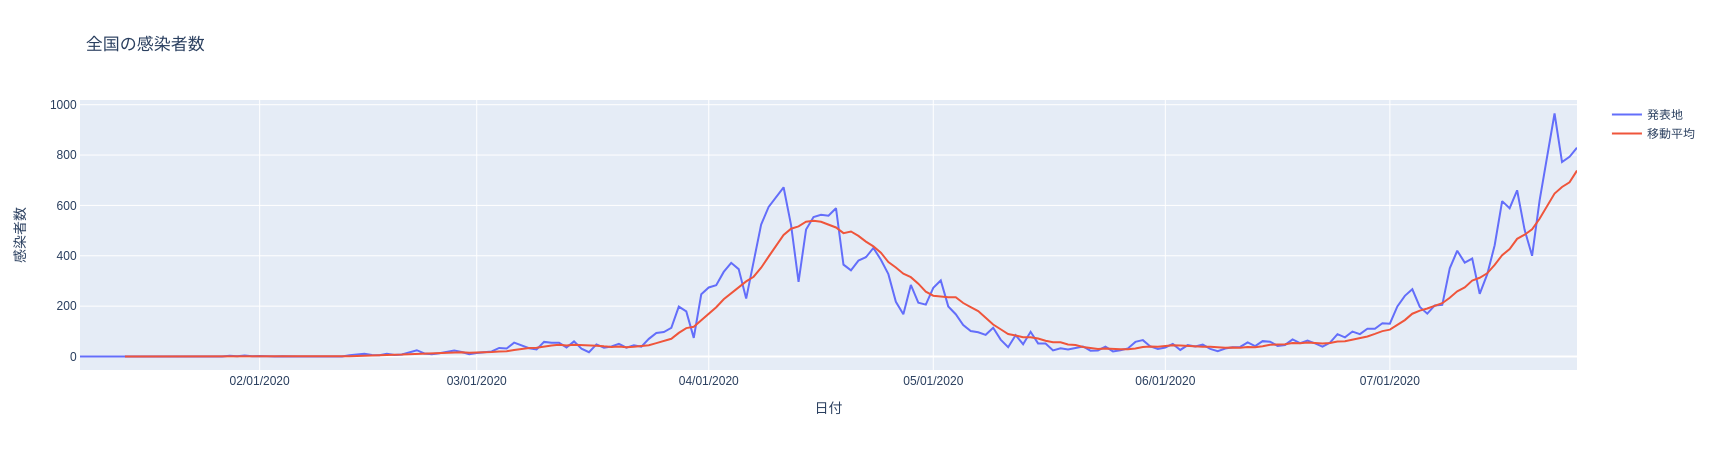

In [95]:
plot_data("全国", df=df_covid)

In [87]:
days_japanese = ["月曜日", "火曜日", "水曜日", "木曜日", "金曜日", "土曜日", "日曜日"]

In [88]:
def make_plot(df=df, pref="全国", window=7, round_to=100):
    count_max = ceil_to(df[pref].max(), round_to)
    df1 = df.copy()
    df1["counts_rolling"] = next(rolling(pref, df=df1, window=window))
    df2 = df1.copy()
    df2["date_angle"] = (360/7) * (df2.index.dayofweek + (df2.index.week - 1) * 7)
    df2 = df2.resample("30T").interpolate()
    df2["date_str"] = df2.index.strftime("%Y-%m-%d")
    df2["day_of_week"] = df2.index.dayofweek
    df2["counts"] = df[pref].resample("30T").ffill()
    
    fig = make_subplots(cols=3, specs=[[
        dict(type="xy"),
        dict(type="scatterpolar"),
        dict(type="scatterpolar"),
    ]])

    fig.add_trace(go.Scatterpolar(
        r=df2[pref],
        theta=df2.date_angle,
        hovertemplate="%{text}",
        text=[f"<b>{row.date_str}（{days_japanese[row.day_of_week][0]}）</b><br>感染者数：{row.counts:.0f}人" for i, row in df2.iterrows()],
        name="発表値",
    ), row=1, col=2)

    fig.add_trace(go.Scatterpolar(
        r=next(rolling(pref, df=df2, window=window*24*2)),
        theta=df2.date_angle,
        hovertemplate="%{text}",
        text=[f"<b>{row.date_str}（{days_japanese[row.day_of_week][0]}）</b><br>感染者数：{row.counts_rolling:.0f}人" for i, row in df2.iterrows()],
        name="移動平均",
    ), row=1, col=3)
    
    today_line = go.Scatterpolar(
        r=[0, count_max],
        theta=[df2.date_angle[-1], df2.date_angle[-1]],
        line=dict(color="black"),
        showlegend=False,
        mode="lines",
    )
    fig.add_trace(today_line, row=1, col=2)
    fig.add_trace(today_line, row=1, col=3)

    fig.add_trace(go.Scatter(
        x=df1.index,
        y=df[pref],
        name="発表地",
        line=dict(color=px.colors.qualitative.Plotly[0]),
        showlegend=False,
        hovertemplate="%{text}",
        text=[f"{row[pref]:.0f}人" for i, row in df1.iterrows()],
    ))
    fig.add_trace(go.Scatter(
        x=df1.index,
        y=next(rolling(pref, df=df, window=window)),
        name="移動平均",
        line=dict(color=px.colors.qualitative.Plotly[1]),
        showlegend=False,
        hovertemplate="%{text}",
        text=[f"{row.counts_rolling:.0f}人" for i, row in df1.iterrows()],
    ))

    fig.update_polars(
        radialaxis=dict(
            range=[0, count_max],
            angle=90,
            tickvals=np.arange(0, count_max+1, ceil_to(count_max // 5, round_to // 2)),
            tickangle=90,
        ),
        angularaxis=dict(
            direction="clockwise",
            ticktext=days_japanese,
            tickvals=np.arange(0, 360, 360/7),
        )
    )
    
    fig.update_xaxes(
        tickformat="%Y年%m月%d日（%a）",
    )

    end_time = dt.datetime.strftime(df1.index[-1], "%Y年%m月%d日（%a）")
    current_time = dt.datetime.strftime(dt.datetime.now(), "%Y年%m月%d日%H:%M")
    
    fig.update_layout(
        title=f"{pref}の感染状況（{end_time}まで）",
        hovermode="x unified",
        xaxis_title="日付",
        yaxis_title="感染者数",
    )
    
    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=1.08,
        y=-0.2,
        showarrow=False,
        text=(
            "作者: @_masasin"
        ),
    )   
    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=1.08,
        y=-0.25,
        showarrow=False,
        text=(
            f"グラフ更新日時: {current_time}現在"
        ),
    )
    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=1.08,
        y=-0.3,
        showarrow=False,
        text=(
            f"ソース: {NHK_JSON}"
        ),
    )
    return fig

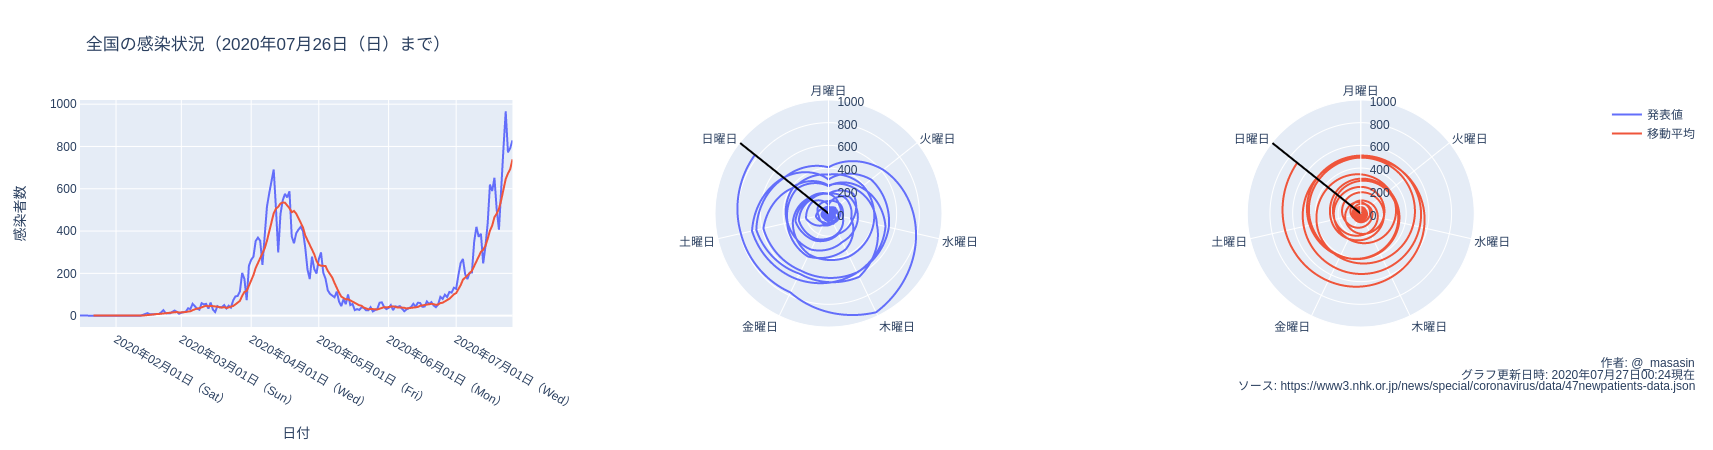

In [89]:
make_plot(df, "全国")

In [90]:
def plot_for_animation(date_end=None, date_start="2020-01-16", pref="全国"):
    if date_end is None:
        date_end = df.index[-1]
    return make_plot(df[date_start:date_end], pref=pref)

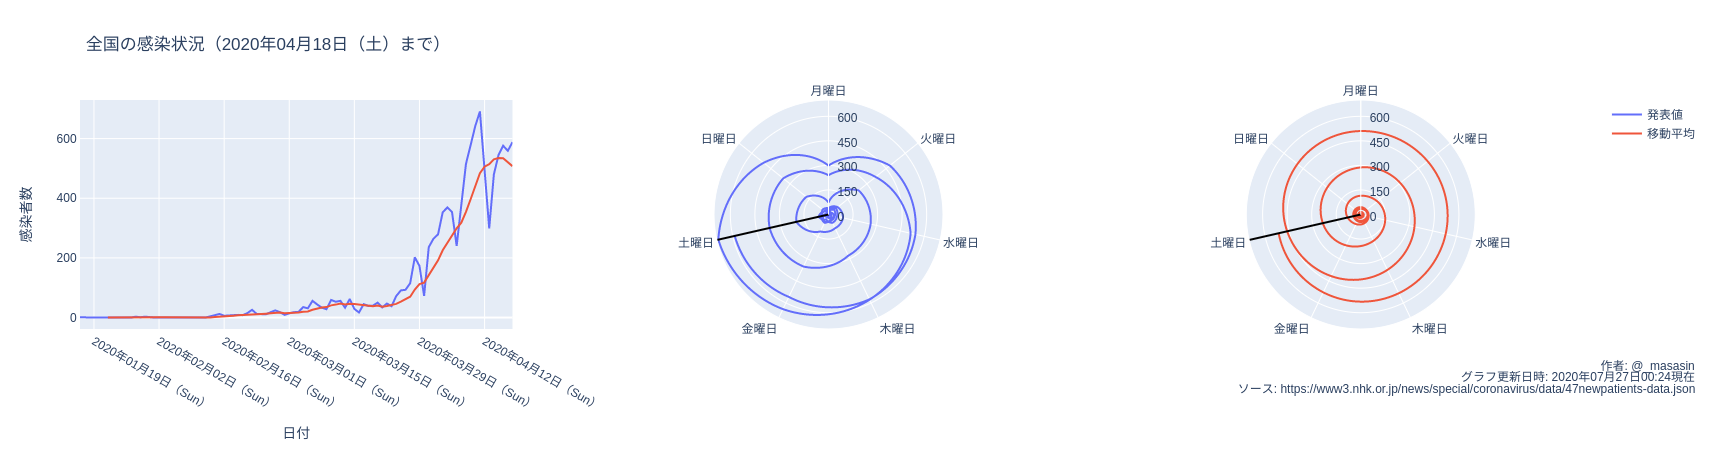

In [91]:
plot_for_animation(date_end="2020-04-18")